# 2016-2020 Presidential Election Voting and Demographic Analysis
This project aims to understand how demographic data can be used to predict measures of voting such as turnout change and electoral margin shift. We use precinct-level data from [Dave's Redistricting App](https://davesredistricting.org/) and save data for each state into a separate CSV file using the filename format 'precinct-data-{state abbreviation}.csv'.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans

## Data Wrangling

In [2]:
states = ['AZ', 'GA', 'NC', 'TX']

In [3]:
df = pd.read_csv('precinct-data-AZ.csv') # Read in one example file to look at what are the relevant columns

In [4]:
df.shape

(1678, 114)

In [5]:
[*df.columns]

['GEOID20',
 'District',
 'FriendlyId',
 'Total_2016-2020_Comp',
 'Dem_2016-2020_Comp',
 'Rep_2016-2020_Comp',
 'Total_2020_Sen',
 'Dem_2020_Sen',
 'Rep_2020_Sen',
 'Total_2020_Pres',
 'Dem_2020_Pres',
 'Rep_2020_Pres',
 'Total_2018_Sen',
 'Dem_2018_Sen',
 'Rep_2018_Sen',
 'Total_2018_AG',
 'Dem_2018_AG',
 'Rep_2018_AG',
 'Total_2018_Gov',
 'Dem_2018_Gov',
 'Rep_2018_Gov',
 'Total_2016_Sen',
 'Dem_2016_Sen',
 'Rep_2016_Sen',
 'Total_2016_Pres',
 'Dem_2016_Pres',
 'Rep_2016_Pres',
 'Total_2019_CVAP',
 'White_2019_CVAP',
 'Hispanic_2019_CVAP',
 'Black_2019_CVAP',
 'Asian_2019_CVAP',
 'Native_2019_CVAP',
 'Pacific_2019_CVAP',
 'BlackAlone_2019_CVAP',
 'AsianAlone_2019_CVAP',
 'NativeAlone_2019_CVAP',
 'OtherAlone_2019_CVAP',
 'TwoOrMore_2019_CVAP',
 'Total_2019_Total',
 'White_2019_Total',
 'Hispanic_2019_Total',
 'Black_2019_Total',
 'Asian_2019_Total',
 'Native_2019_Total',
 'Pacific_2019_Total',
 'BlackAlone_2019_Total',
 'NativeAlone_2019_Total',
 'Total_2020_VAP',
 'White_2020_VAP',


In [6]:
cols = [col for col in df.columns if 'Pres' in col or '2020_VAP' in col and '.1' not in col and 'Alone' not in col]
cols

['Total_2020_Pres',
 'Dem_2020_Pres',
 'Rep_2020_Pres',
 'Total_2016_Pres',
 'Dem_2016_Pres',
 'Rep_2016_Pres',
 'Total_2020_VAP',
 'White_2020_VAP',
 'Hispanic_2020_VAP',
 'Black_2020_VAP',
 'Asian_2020_VAP',
 'Native_2020_VAP',
 'Pacific_2020_VAP']

In [7]:
def df_wrangle(state_abbrev):
    '''
    INPUT
        state_abbrev - two-letter string with state abbreviation
    
    OUTPUT
        df - dataframe with 2016, 2020 presidential election results and 2020 census demographics
    '''
    
    df = pd.read_csv('precinct-data-{}.csv'.format(state_abbrev))
    df = df[cols]
    
    df = df[(df['Total_2020_Pres'] >= 100) & (df['Total_2016_Pres'] >= 100)]
    
    df.insert(0, 'State', state_abbrev)
    
    # The presidential margins are calculated for all precincts in both races as percentage values.
    df.insert(4, 'Dem_Rep_2020_Margin', (df['Dem_2020_Pres'] - df['Rep_2020_Pres']) / df['Total_2020_Pres'] * 100)
    df.insert(7, 'Dem_Rep_2016_Margin', (df['Dem_2016_Pres'] - df['Rep_2016_Pres']) / df['Total_2016_Pres'] * 100)
    df.insert(8, 'Margin_Shift', df['Dem_Rep_2020_Margin'] - df['Dem_Rep_2016_Margin'])
    
    # Turnout change for each party by precinct was also calculated as a percentage rate.
    df.insert(9, 'Dem_Turnout_Change', (df['Dem_2020_Pres'] - df['Dem_2016_Pres']) / df['Dem_2016_Pres'] * 100)
    df.insert(10, 'Rep_Turnout_Change', (df['Rep_2020_Pres'] - df['Rep_2016_Pres']) / df['Rep_2016_Pres'] * 100)
    
    # Infinity values for the turnout change rates are replaced with NaNs that are then dropped.
    df.replace(to_replace=np.inf, value=np.nan, inplace=True)
    df.dropna(subset=['Dem_Rep_2020_Margin', 'Dem_Rep_2016_Margin', 'Dem_Turnout_Change', 'Rep_Turnout_Change'],
              inplace=True)
    
    # Each demographic has its percentage of the precinct's voting-age population calculated in separate columns.
    df['White_Perc'] = df['White_2020_VAP'] / df['Total_2020_VAP'] * 100
    df['Hispanic_Perc'] = df['Hispanic_2020_VAP'] / df['Total_2020_VAP'] * 100
    df['Black_Perc'] = df['Black_2020_VAP'] / df['Total_2020_VAP'] * 100
    df['Asian_Perc'] = df['Asian_2020_VAP'] / df['Total_2020_VAP'] * 100
    df['Native_Perc'] = df['Native_2020_VAP'] / df['Total_2020_VAP'] * 100
    df['Pacific_Perc'] = df['Pacific_2020_VAP'] / df['Total_2020_VAP'] * 100
    
    # All racial demographic percentage values less than 100% are dropped.
    df = df[(df['White_Perc'] <= 100) & (df['Hispanic_Perc'] <= 100) & (df['Black_Perc'] <= 100) &
            (df['Asian_Perc'] <= 100) & (df['Native_Perc'] <= 100) & (df['Pacific_Perc'] <= 100)]
    
    return df

In [8]:
df_states = pd.DataFrame()
for state in states:
    df_states = pd.concat([df_states, df_wrangle(state)])

In [9]:
df_states = pd.get_dummies(df_states, columns=['State'])

In [10]:
df_states.describe()

,Total_2020_Pres,Dem_2020_Pres,Rep_2020_Pres,Dem_Rep_2020_Margin,Total_2016_Pres,Dem_2016_Pres,Dem_Rep_2016_Margin,Margin_Shift,Dem_Turnout_Change,Rep_Turnout_Change,...,White_Perc,Hispanic_Perc,Black_Perc,Asian_Perc,Native_Perc,Pacific_Perc,State_AZ,State_GA,State_NC,State_TX
count,14800.000000,14800.000000,14800.000000,14800.000000,14800.000000,14800.000000,14800.000000,14800.000000,14800.000000,14800.000000,...,14800.000000,14800.000000,14800.000000,14800.000000,14800.000000,14800.000000,14800.000000,14800.000000,14800.000000,14800.000000
mean,1695.757027,813.296824,857.837365,-4.687862,1373.222027,612.705878,-6.356181,1.668318,33.771505,32.159006,...,57.729323,20.584104,16.967527,2.771034,1.755979,0.071100,0.103108,0.178311,0.178311,0.540270
std,1339.653560,744.153089,826.414253,47.046848,1030.692743,551.208193,48.641092,10.126874,49.493996,50.369010,...,28.753759,24.642040,22.364519,5.226556,7.986928,0.532292,0.304110,0.382787,0.382787,0.498393
min,100.000000,2.000000,2.000000,-98.054475,100.000000,1.000000,-97.794118,-69.953449,-74.437219,-80.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,719.000000,247.000000,279.000000,-45.166522,605.000000,194.000000,-47.713995,-2.946411,13.596827,11.619785,...,35.383236,3.433068,1.751095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1410.000000,630.000000,637.000000,-5.014966,1179.000000,478.000000,-11.779512,2.445166,28.695966,20.574384,...,64.451386,10.383713,7.482876,0.862069,0.454305,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2324.250000,1160.000000,1183.000000,30.604165,1900.250000,869.000000,31.652328,7.949359,44.339623,35.331756,...,82.066211,27.650188,22.747890,3.214047,1.349318,0.000000,0.000000,0.000000,0.000000,1.000000
max,23433.000000,9135.000000,18024.000000,97.807018,18603.000000,7148.000000,98.268398,79.536988,1911.475410,1984.210526,...,100.000000,100.000000,100.000000,96.706587,100.000000,35.897436,1.000000,1.000000,1.000000,1.000000


In [11]:
df_states.columns

Index(['Total_2020_Pres', 'Dem_2020_Pres', 'Rep_2020_Pres',
       'Dem_Rep_2020_Margin', 'Total_2016_Pres', 'Dem_2016_Pres',
       'Dem_Rep_2016_Margin', 'Margin_Shift', 'Dem_Turnout_Change',
       'Rep_Turnout_Change', 'Rep_2016_Pres', 'Total_2020_VAP',
       'White_2020_VAP', 'Hispanic_2020_VAP', 'Black_2020_VAP',
       'Asian_2020_VAP', 'Native_2020_VAP', 'Pacific_2020_VAP', 'White_Perc',
       'Hispanic_Perc', 'Black_Perc', 'Asian_Perc', 'Native_Perc',
       'Pacific_Perc', 'State_AZ', 'State_GA', 'State_NC', 'State_TX'],
      dtype='object')

In [12]:
df_states.shape

(14800, 28)

In [13]:
# Check how many NaN values there are total in the full dataset
df_states.isna().any().sum()

0

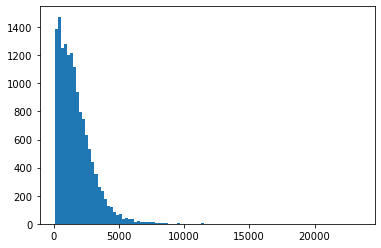

In [14]:
plt.hist(df_states['Total_2020_Pres'], bins=100);

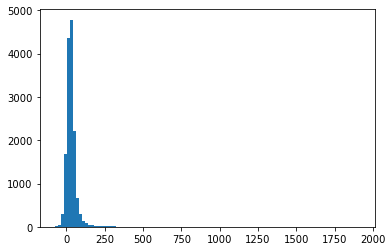

In [15]:
plt.hist(df_states['Dem_Turnout_Change'], bins=100);

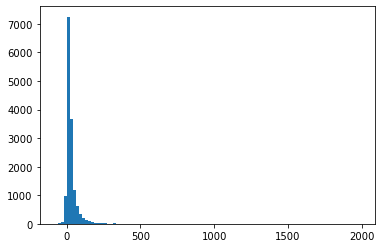

In [16]:
plt.hist(df_states['Rep_Turnout_Change'], bins=100);

Seeing that some of the turnout change rates are well into the thousands of a percent, those precincts are more likely to have smaller populations, so we filter those out from the dataset.

In [17]:
print(df_states.shape)
df_states.query('(Dem_Turnout_Change <= 200) & (Rep_Turnout_Change <= 200)').shape

(14800, 28)


(14575, 28)

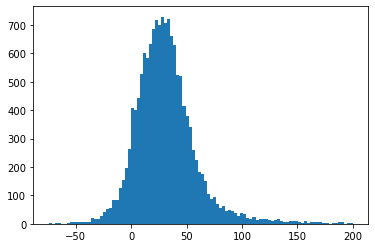

In [18]:
plt.hist(df_states.query('(Dem_Turnout_Change <= 200) & (Rep_Turnout_Change <= 200)')['Dem_Turnout_Change'], bins=100);

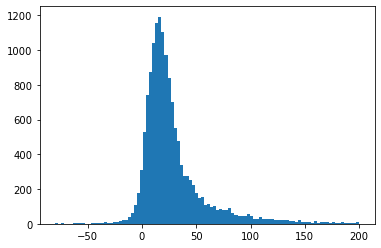

In [19]:
plt.hist(df_states.query('(Dem_Turnout_Change <= 200) & (Rep_Turnout_Change <= 200)')['Rep_Turnout_Change'], bins=100);

In [20]:
df_states = df_states.query('(Dem_Turnout_Change <= 200) & (Rep_Turnout_Change <= 200)')

In [21]:
# The Pacific population data can be dropped since none of these states have large Pacific populations.
df_states.drop(columns='Pacific_Perc', inplace=True)

## Understanding the Data

In [22]:
def state_regplots(x_var, y_var, xlabel, ylabel, length, width, alpha, fit_reg):
    '''
    Displays scatterplots with linear regression fits between two specified variables for each state side by side.
    
    INPUT
        x_var - x variable string in scatterplot; must be valid column name in df_states
        y_var - y variable string in scatterplot; must be valid column name in df_states
        xlabel - x-axis label
        ylabel - y-axis label
        length - figure length (horizontal)
        width - figure width (vertical)
        alpha - data point transparency
        fit_reg - bool value for displaying linear regression fit
    '''
    fig, ax = plt.subplots(1, len(states), sharey=True, figsize=[length, width])
    
    for i, state in enumerate(states):
        sb.regplot(data=df_states.query('State_{} == 1'.format(state)), x=x_var, y=y_var, scatter_kws={'alpha': alpha}, ax=ax[i], fit_reg=fit_reg)
        ax[i].set_title(state)
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        ax[i].label_outer()

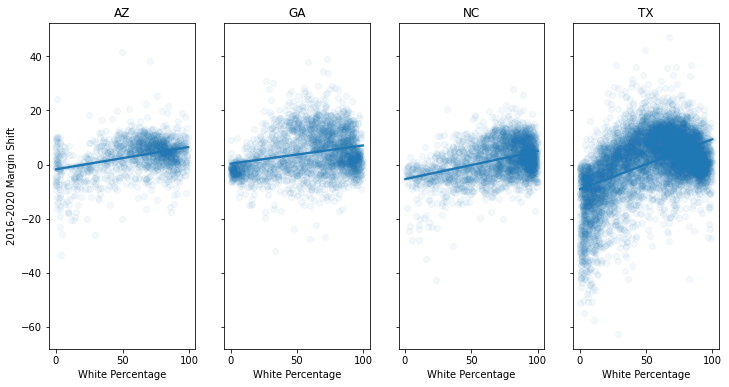

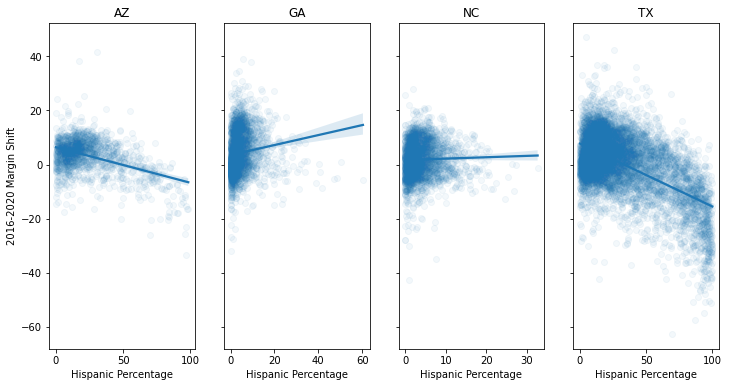

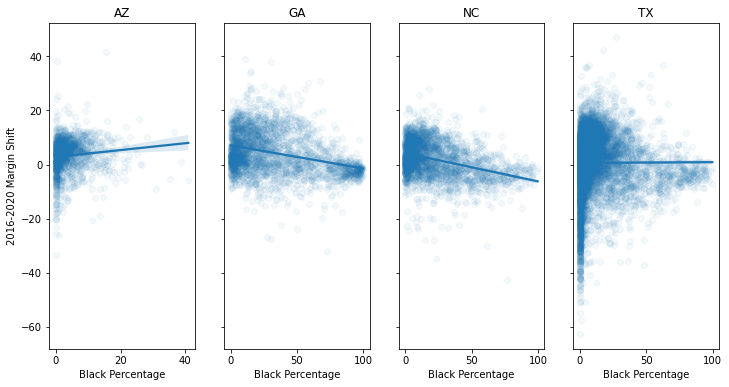

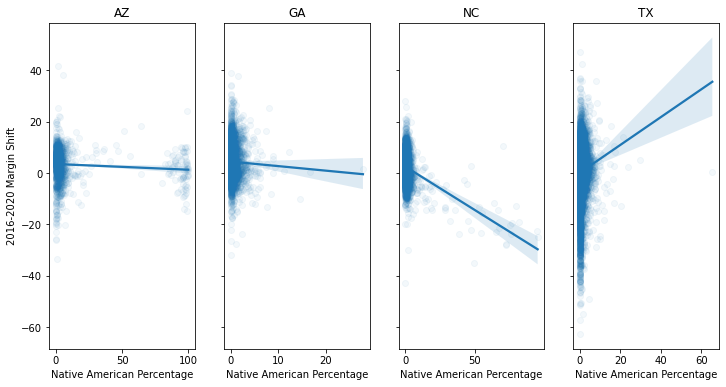

In [23]:
state_regplots('White_Perc', 'Margin_Shift', 'White Percentage', '2016-2020 Margin Shift', 12, 6, 1/20, True)
state_regplots('Hispanic_Perc', 'Margin_Shift', 'Hispanic Percentage', '2016-2020 Margin Shift', 12, 6, 1/20, True)
state_regplots('Black_Perc', 'Margin_Shift', 'Black Percentage', '2016-2020 Margin Shift', 12, 6, 1/20, True)
state_regplots('Native_Perc', 'Margin_Shift', 'Native American Percentage', '2016-2020 Margin Shift', 12, 6, 1/20, True)

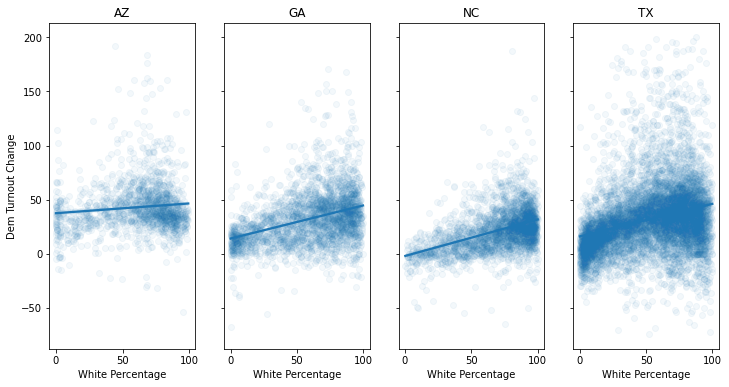

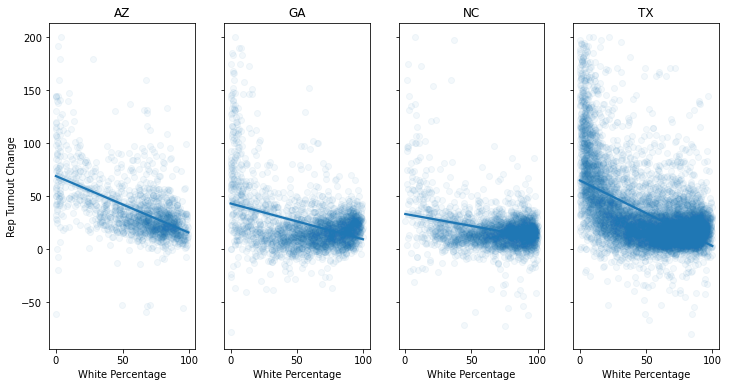

In [24]:
state_regplots('White_Perc', 'Dem_Turnout_Change', 'White Percentage', 'Dem Turnout Change', 12, 6, 1/20, True)
state_regplots('White_Perc', 'Rep_Turnout_Change', 'White Percentage', 'Rep Turnout Change', 12, 6, 1/20, True)

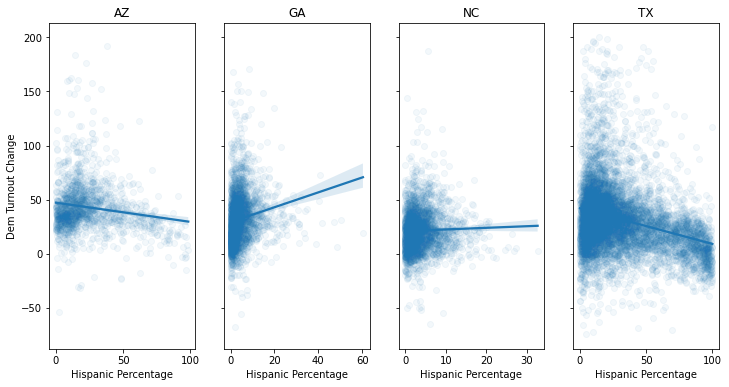

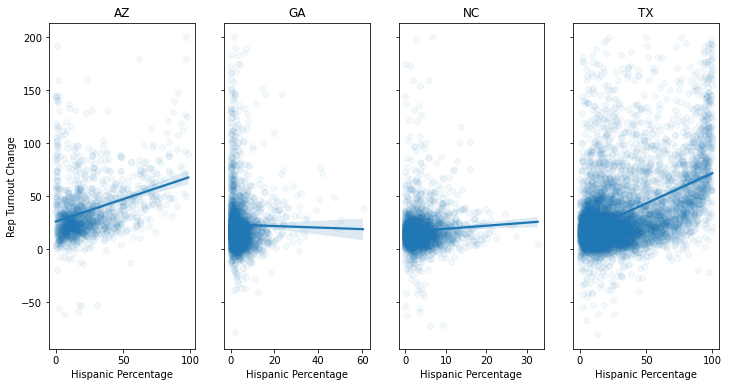

In [25]:
state_regplots('Hispanic_Perc', 'Dem_Turnout_Change', 'Hispanic Percentage', 'Dem Turnout Change', 12, 6, 1/20, True)
state_regplots('Hispanic_Perc', 'Rep_Turnout_Change', 'Hispanic Percentage', 'Rep Turnout Change', 12, 6, 1/20, True)

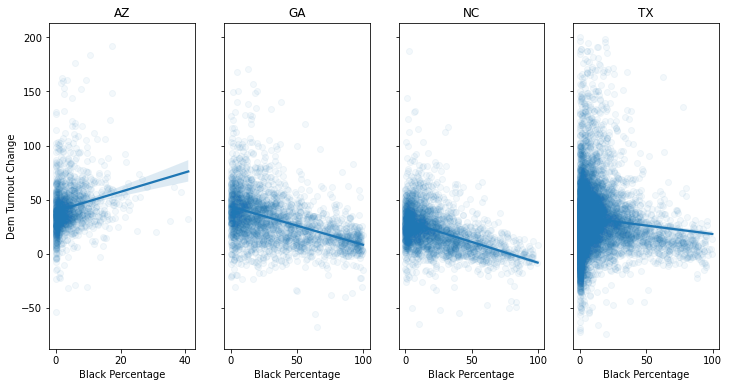

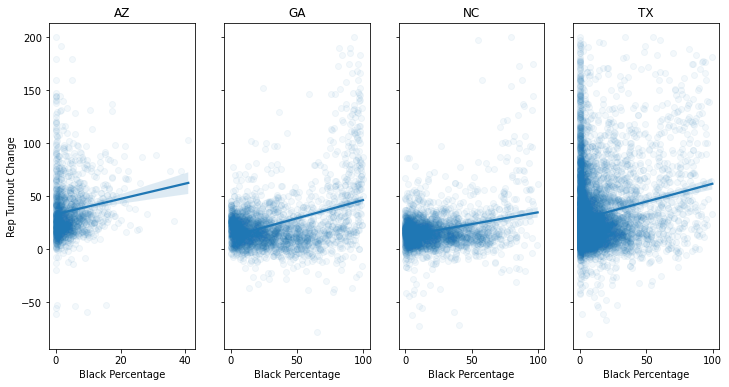

In [26]:
state_regplots('Black_Perc', 'Dem_Turnout_Change', 'Black Percentage', 'Dem Turnout Change', 12, 6, 1/20, True)
state_regplots('Black_Perc', 'Rep_Turnout_Change', 'Black Percentage', 'Rep Turnout Change', 12, 6, 1/20, True)

Based on the regression plots above, a linear fit can be used to approvimate how racial demographics might correlate to various electoral metrics. The error may be large, but the fit can still point to correlations.

## How does the change in Dem/Rep turnout scale with each demographic across all four states?

In [27]:
df_states.columns

Index(['Total_2020_Pres', 'Dem_2020_Pres', 'Rep_2020_Pres',
       'Dem_Rep_2020_Margin', 'Total_2016_Pres', 'Dem_2016_Pres',
       'Dem_Rep_2016_Margin', 'Margin_Shift', 'Dem_Turnout_Change',
       'Rep_Turnout_Change', 'Rep_2016_Pres', 'Total_2020_VAP',
       'White_2020_VAP', 'Hispanic_2020_VAP', 'Black_2020_VAP',
       'Asian_2020_VAP', 'Native_2020_VAP', 'Pacific_2020_VAP', 'White_Perc',
       'Hispanic_Perc', 'Black_Perc', 'Asian_Perc', 'Native_Perc', 'State_AZ',
       'State_GA', 'State_NC', 'State_TX'],
      dtype='object')

In [28]:
X = df_states[[col for col in df_states.columns if 'Perc' in col]].drop(columns='White_Perc')
y_dem = df_states['Dem_Turnout_Change']
y_rep = df_states['Rep_Turnout_Change']

In [29]:
X.columns

Index(['Hispanic_Perc', 'Black_Perc', 'Asian_Perc', 'Native_Perc'], dtype='object')

### Dem Turnout

In [30]:
X_dem_train, X_dem_test, y_dem_train, y_dem_test = train_test_split(X, y_dem, test_size=0.3, random_state=42)

In [31]:
lm_dem = LinearRegression()
lm_dem.fit(X_dem_train, y_dem_train)
y_dem_pred = lm_dem.predict(X_dem_test)
r2_score(y_dem_test, y_dem_pred)

0.11619908214513253

In [32]:
dem_coefs = pd.concat([pd.DataFrame(data=lm_dem.coef_, columns=['coefficients'], index=lm_dem.feature_names_in_) , 
           pd.DataFrame(data=lm_dem.intercept_, index=['intercept'], columns=['coefficients'])])

### Rep Turnout

In [33]:
X_rep_train, X_rep_test, y_rep_train, y_rep_test = train_test_split(X, y_rep, test_size=0.3, random_state=42)

In [34]:
lm_rep = LinearRegression()
lm_rep.fit(X_rep_train, y_rep_train)
y_rep_pred = lm_rep.predict(X_rep_test)
r2_score(y_rep_test, y_rep_pred)

0.26428254234928883

In [36]:
rep_coefs = pd.concat([pd.DataFrame(data=lm_rep.coef_, index=lm_rep.feature_names_in_, columns=['coefficients']),
           pd.DataFrame(data=lm_rep.intercept_, index=['intercept'], columns=['coefficients'])])

### Discussion
The linear regression models above to predict Dem/Rep turnout change from 2016 to 2020 were fitted against precinct-level Hispanic, Black, Asian, and Native demographic figures. Pacific Islander demographics were excluded since none of the states' populations have significant levels of that racial group. I also dropped the white demographic feature so that the numerical features being fitted weren't linearly dependent, which means that the intercept from the linear regression fit should be interpreted as the change in turnout for that party in a 100% white precinct. The other coefficients represent the amount of increase or decrease in turnout change between the elections for every increase in percentage of the precinct population that racial demographic represents.

| | Democrat | Republican |
| -:| :-: | :-: |
| **Relative turnout from 2016 to 2020 for 100% white precinct** | +38.99% | +7.82% |
| **Change in relative turnout for each additional 1% in Hispanic population** | -0.23% | +0.64% |
| **Change in relative turnout for each additional 1% in black population** | -0.34% | +0.36% |
| **Change in relative turnout for each additional 1% in Asian population** | +0.97% | +0.19% |
| **Change in relative turnout for each additional 1% in Native population** | -0.04% | +0.58% |

It's clear while both parties saw an increase in turnout for all races in the four states, the greatest increases in Democratic turnout appeared to be in more white and Asian precincts, while the greatest increases in Republican turnout were in more Hispanic, Native, and to a lesser extent black precincts. With that said, both regression models had low R-squared scores, largely due to clusters of points at low values of each demographic portion that had high variance in relative turnout for either party. A polynomial regression model could improve upon the linear fit, especially if it accounts for interaction between two or more demographics, which would make sense since an increase in one demographic portion would be connected to a decrease in another.

## How did racial demographics and voting-age population affect the election margin by precinct?

In [36]:
df_states.columns

Index(['Total_2020_Pres', 'Dem_2020_Pres', 'Rep_2020_Pres',
       'Dem_Rep_2020_Margin', 'Total_2016_Pres', 'Dem_2016_Pres',
       'Dem_Rep_2016_Margin', 'Margin_Shift', 'Dem_Turnout_Change',
       'Rep_Turnout_Change', 'Rep_2016_Pres', 'Total_2020_VAP',
       'White_2020_VAP', 'Hispanic_2020_VAP', 'Black_2020_VAP',
       'Asian_2020_VAP', 'Native_2020_VAP', 'Pacific_2020_VAP', 'White_Perc',
       'Hispanic_Perc', 'Black_Perc', 'Asian_Perc', 'Native_Perc', 'State_AZ',
       'State_GA', 'State_NC', 'State_TX'],
      dtype='object')

In [37]:
X_marg = df_states[[col for col in df_states.columns if 'Perc' in col]
              + ['Total_2020_VAP']
              + [col for col in df_states.columns if 'State_' in col]].drop(columns=['White_Perc', 'State_AZ'])
y_marg = df_states['Margin_Shift']

In [38]:
X_marg.describe()

,Hispanic_Perc,Black_Perc,Asian_Perc,Native_Perc,Total_2020_VAP,State_GA,State_NC,State_TX
count,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000
mean,20.319562,16.859633,2.749621,1.760977,2606.782985,0.179485,0.180789,0.535849
std,24.324146,22.161878,5.145894,7.967580,1928.260664,0.383771,0.384856,0.498730
min,0.000000,0.000000,0.000000,0.000000,56.000000,0.000000,0.000000,0.000000
25%,3.400175,1.762581,0.000000,0.000000,1235.000000,0.000000,0.000000,0.000000
50%,10.278373,7.488987,0.862866,0.459559,2273.000000,0.000000,0.000000,1.000000
75%,27.314151,22.566509,3.200844,1.358465,3525.500000,0.000000,0.000000,1.000000
max,100.000000,100.000000,96.706587,100.000000,34028.000000,1.000000,1.000000,1.000000


In [39]:
X_marg_train, X_marg_test, y_marg_train, y_marg_test = train_test_split(X_marg, y_marg, test_size=0.3, random_state=42)

In [40]:
lm_marg = LinearRegression()
lm_marg.fit(X_marg_train, y_marg_train)
y_marg_pred = lm_marg.predict(X_marg_test)
r2_score(y_marg_test, y_marg_pred)

0.325403660525744

In [41]:
pd.concat([pd.DataFrame(data=lm_marg.coef_, index=lm_marg.feature_names_in_, columns=['All states coefficients']),
           pd.DataFrame(data=lm_marg.intercept_, index=['intercept'], columns=['All states coefficients'])])

,All states coefficients
Hispanic_Perc,-0.220428
Black_Perc,-0.083222
Asian_Perc,0.223590
Native_Perc,-0.070058
Total_2020_VAP,0.000893
State_GA,-1.057794
State_NC,-4.010616
State_TX,-0.141068
intercept,5.821605


In [42]:
def state_margin_shift(state):
    '''
    INPUT
        state - string with abbreviation for state; must be in states list
    
    OUTPUT
        Prints the R-squared score for the linear regression fit between the margin shift by precinct
            and the numerical features for the specified state
        Returns a DataFrame with all the coefficients of the regression fit, including an intercept
    '''
    
    X_marg = df_states.query('State_{} == 1'.format(state))[[col for col in df_states.columns if 'Perc' in col]
                                                            + ['Total_2020_VAP']
                                                            + [col for col in df_states.columns if 'State_' in col]]
    X_marg.drop(columns=['White_Perc'] + [col for col in df_states.columns if 'State_' in col], inplace=True)
    y_marg = df_states.query('State_{} == 1'.format(state))['Margin_Shift']
    X_marg_train, X_marg_test, y_marg_train, y_marg_test = train_test_split(X_marg, y_marg, test_size=0.3, random_state=42)
    lm_marg = LinearRegression()
    lm_marg.fit(X_marg_train, y_marg_train)
    y_marg_pred = lm_marg.predict(X_marg_test)
    print('R-squared score for {}: {}'.format(state, r2_score(y_marg_test, y_marg_pred)))
    return pd.concat([pd.DataFrame(data=lm_marg.coef_, index=lm_marg.feature_names_in_, columns=['{} coefficients'.format(state)]),
                      pd.DataFrame(data=lm_marg.intercept_, index=['intercept'], columns=['{} coefficients'.format(state)])])

In [43]:
for state in states:
    display(state_margin_shift(state))

R-squared score for AZ: 0.21413488009474058


,AZ coefficients
Hispanic_Perc,-0.145558
Black_Perc,0.206681
Asian_Perc,0.345090
Native_Perc,-0.028183
Total_2020_VAP,0.000106
intercept,4.775761


R-squared score for GA: 0.21750088485194652


,GA coefficients
Hispanic_Perc,0.009541
Black_Perc,-0.078971
Asian_Perc,0.358746
Native_Perc,-0.285755
Total_2020_VAP,0.000673
intercept,4.092090


R-squared score for NC: 0.2614298671190166


,NC coefficients
Hispanic_Perc,0.014974
Black_Perc,-0.104659
Asian_Perc,0.338163
Native_Perc,-0.352739
Total_2020_VAP,0.000802
intercept,1.920994


R-squared score for TX: 0.40280572901170386


,TX coefficients
Hispanic_Perc,-0.233296
Black_Perc,-0.083051
Asian_Perc,0.114848
Native_Perc,-0.043958
Total_2020_VAP,0.001324
intercept,5.488382


### Discussion
First I used the entire dataset, including the dummy variables for the states, to construct a linear regression model that fit data for precincts across all four states. This was to determine if the precinct's state had an impact on the shift in the presidential election margin from 2016 to 2020. By dropping the white percentage of the population and the State_AZ column, I had the intercept refer to the margin shift in a 100% white precinct in Arizona, which on average saw a 5.82% margin shift. It seemed apparent that the more black, Native, or especially Hispanic a precinct was, the less likely it was to shift left, while more Asian precincts and very populous precincts were more likely to shift more left.


| | Change in 2016-2020 margin shift |
| -: | :-: |
| Change in shift per additional 1% in Hispanic population | -0.22% |
| Change in shift per additional 1% in black population |	-0.08% |
| Change in shift per additional 1% in Asian population | +0.22% |
| Change in shift per additional 1% in Native population | -0.07% |
| Change in shift per 1000 voting age people | +0.89% |
| If state is Georgia | -1.06% |
| If state is North Carolina | -4.01% |
| If state is Texas | -0.14% |

Then I looked at how these factors affected the margins for precincts within each state alone. Across all four states, it's clear that the more Hispanic and black precincts were less likely to shift left than white precincts, while Asian precincts and very populous precnicts were more likely to shift left. However, when looking at specific states, we see some key differences. For example, white precincts in North Carolina shifted less to the left than in other states, and Hispanic precincts in Texas shifted more to the right than in other states.

| | AZ | GA | NC | TX |
| -: | :-: | :-: | :-: | :-: |
| Margin shift in 100% white precinct | +4.78% | +4.09% | +1.92% | +5.49% |
| Change in shift per additional 1% in Hispanic population | -0.15% | +0.01% | +0.01% | -0.23% |
| Change in shift per additional 1% in black population | +0.21% | -0.08% | -0.1% | -0.08% |
| Change in shift per additional 1% in Asian population | +0.35% | +0.36% | +0.34% | +0.11% |
| Change in shift per additional 1% in Native population | -0.03% | -0.29% | -0.35% | -0.04% |
| Change in shift per 1000 voting age people | +0.11% | +0.67% | +0.8% | +1.3% |

## How many general but distinct groups of precincts can be put together based on state and racial composition?

In [44]:
df_states.columns

Index(['Total_2020_Pres', 'Dem_2020_Pres', 'Rep_2020_Pres',
       'Dem_Rep_2020_Margin', 'Total_2016_Pres', 'Dem_2016_Pres',
       'Dem_Rep_2016_Margin', 'Margin_Shift', 'Dem_Turnout_Change',
       'Rep_Turnout_Change', 'Rep_2016_Pres', 'Total_2020_VAP',
       'White_2020_VAP', 'Hispanic_2020_VAP', 'Black_2020_VAP',
       'Asian_2020_VAP', 'Native_2020_VAP', 'Pacific_2020_VAP', 'White_Perc',
       'Hispanic_Perc', 'Black_Perc', 'Asian_Perc', 'Native_Perc', 'State_AZ',
       'State_GA', 'State_NC', 'State_TX'],
      dtype='object')

In [45]:
df_states.head()

,Total_2020_Pres,Dem_2020_Pres,Rep_2020_Pres,Dem_Rep_2020_Margin,Total_2016_Pres,Dem_2016_Pres,Dem_Rep_2016_Margin,Margin_Shift,Dem_Turnout_Change,Rep_Turnout_Change,...,Pacific_2020_VAP,White_Perc,Hispanic_Perc,Black_Perc,Asian_Perc,Native_Perc,State_AZ,State_GA,State_NC,State_TX
0,1398,575,804,-16.380544,1173,444,-19.863598,3.483054,29.504505,18.759232,...,0,84.342784,14.755155,0.000000,1.868557,0.322165,1,0,0,0
1,4390,1104,3237,-48.587699,3599,788,-50.486246,1.898547,40.101523,24.261036,...,15,90.085422,4.411147,0.210055,0.000000,5.097325,1,0,0,0
2,4033,1298,2702,-34.812794,3016,828,-40.782493,5.969699,56.763285,31.292517,...,0,92.088072,1.064602,0.532301,2.371159,1.959835,1,0,0,0
3,3375,1382,1968,-17.362963,2836,1036,-22.284908,4.921945,33.397683,17.985612,...,0,80.764636,9.892473,4.898447,2.747909,1.768220,1,0,0,0
4,844,232,602,-43.838863,716,157,-48.882682,5.043819,47.770701,18.737673,...,0,55.660377,38.679245,0.000000,0.000000,3.430532,1,0,0,0


In [46]:
def cluster_histograms(feature, title):
    plt.figure(figsize=[8,8])
    cluster_inds = np.unique(np.array(cluster_preds))
    for index in cluster_inds:
        bins = np.amax([50, int(cluster_data.iloc[np.where(cluster_preds == index)][feature].max() - cluster_data.iloc[np.where(cluster_preds == index)][feature].min())])
        plt.hist(cluster_data.iloc[np.where(cluster_preds == index)][feature], alpha=0.5, bins=bins, label='{}'.format(index))
        
    plt.title(title)
    plt.legend();

In [47]:
cluster_state = 'AZ'

In [48]:
cluster_data = df_states.query('State_{} == 1'.format(cluster_state))[[col for col in df_states.columns if 'Perc' in col]]
cluster_data.describe()

,White_Perc,Hispanic_Perc,Black_Perc,Asian_Perc,Native_Perc
count,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000
mean,61.618882,23.379184,4.082450,2.593348,7.871426
std,26.488198,20.687721,4.965392,2.924494,21.772137
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.034795,8.596077,0.563170,0.392282,0.424196
50%,68.951150,16.949180,2.463658,1.718270,1.575052
75%,81.962154,31.593657,5.687870,3.838425,3.635286
max,99.233716,98.513800,40.979244,21.529175,100.000000


In [49]:
cluster_data_scaled = pd.DataFrame(data=MaxAbsScaler().fit_transform(cluster_data), columns=cluster_data.columns)
cluster_data_scaled.describe()

,White_Perc,Hispanic_Perc,Black_Perc,Asian_Perc,Native_Perc
count,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000
mean,0.620947,0.237319,0.099622,0.120457,0.078714
std,0.266927,0.209998,0.121168,0.135839,0.217721
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.473980,0.087258,0.013743,0.018221,0.004242
50%,0.694836,0.172049,0.060120,0.079811,0.015751
75%,0.825951,0.320703,0.138799,0.178289,0.036353
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
scores = []
clusters = list(range(1,21))
for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    model=kmeans.fit(cluster_data_scaled)
    
    scores.append(model.score(cluster_data_scaled))

C:\Users\krish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


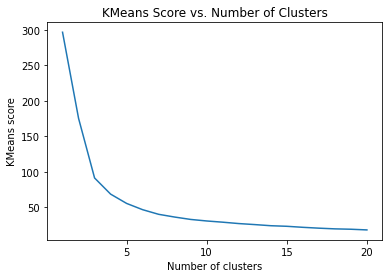

In [51]:
plt.plot(clusters, np.abs(scores))
plt.xlabel('Number of clusters')
plt.ylabel('KMeans score')
plt.title('KMeans Score vs. Number of Clusters')
plt.xticks(np.arange(5,25,5));

C:\Users\krish\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


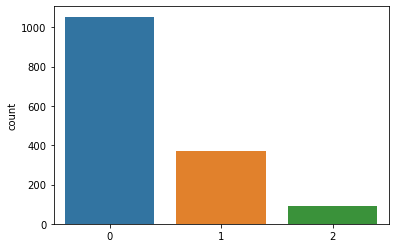

In [52]:
cluster_preds = KMeans(n_clusters=3).fit_predict(cluster_data_scaled)
sb.countplot(cluster_preds);

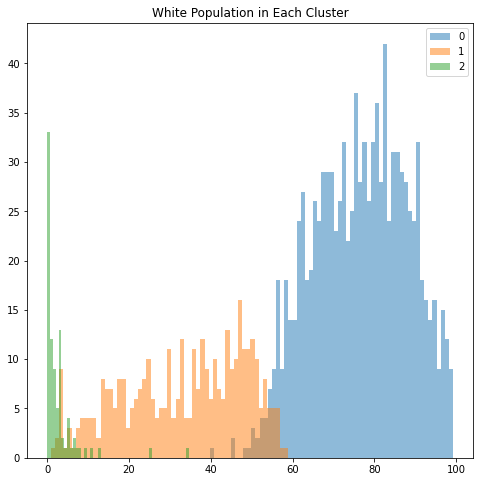

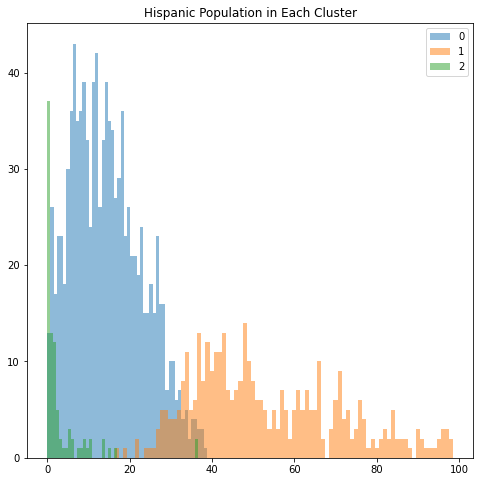

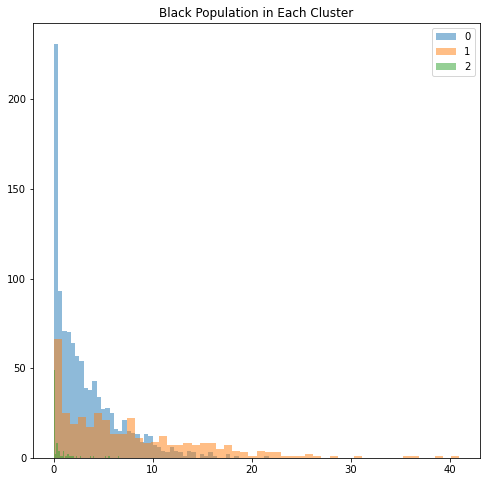

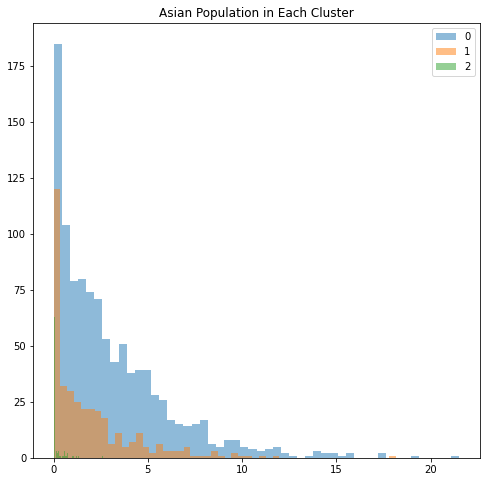

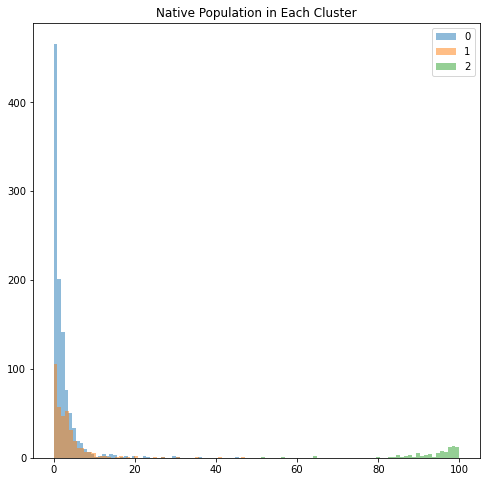

In [53]:
cluster_histograms('White_Perc', 'White Population in Each Cluster')
cluster_histograms('Hispanic_Perc', 'Hispanic Population in Each Cluster')
cluster_histograms('Black_Perc', 'Black Population in Each Cluster')
cluster_histograms('Asian_Perc', 'Asian Population in Each Cluster')
cluster_histograms('Native_Perc', 'Native Population in Each Cluster')

### Discussion
I use a KMeans clustering algorithm with three clusters, which I determined using the elbow method based on how the clustering score changes with the number of clusters, to determine how those clusters differ demographically within each state. As an example, I analyzed the demographic distributions of those clusters for Arizona above by plotting overlayed histograms of each cluster's distribution by demographic. It's clear that Cluster 0 has low percentages of all races except Native Americans, and it also has the smallest number of precincts, which indicates that heavily Native American precincts are a very distinct group from the rest of the state while also a small part of the state's voting population. Meanwhile, Cluster 1 has a lower white and higher Hispanic population, and it's more likely to have precincts with more black voters. Cluster 2, on the other hand, is more likely to have a higher white and lower Hispanic population, and it also has precincts with more Asian voters.  

This analysis can be repeated for the other three states by changing the cluster_state variable above, also using three clusters as seen in the plot of the KMeans score by number of clusters tested.